## Instructions {-}
Ce sujet est constitué de deux parties : la partie 1 correspond au sujet donné l'an dernier, dont la correction vous est donnée, la partie 2 constitue la partie qui sera évaluée et se place dans la continuité de la partie 1.

# Enoncé du problème (Partie 1)

L'objectif de ce projet est d'estimer la longueur de câble sous-marin nécessaire pour relier deux côtes $A$ et $B$  en utilisant des simulations conditionnelles.


Le câble reposera sur le fond marin dont la profondeur est inconnue.
Le segment $[AB]$ est discrétisé par une séquence de (N+1) points. On pose $x_0=A$ et pour $i=1,\dots,N$, $$x_i=x_0+i\Delta$$ où $$\Delta = \frac{AB}{N}$$ de telle sorte que $x_N=B$.
On note $z(x)$ la profondeur du fond marin au point $x$ de telle sorte 
qu'on pourra estimer la longueur totale de câble nécessaire par la somme 
des longueurs sur les segments de la discrétisation :

$$l=\sum_{i=1}^N\sqrt{\Delta^2+(z(x_i)-z(x_{i-1}))^2}.$$

Enfin, notons que l'on dispose d'un ensemble de $n$ observations de la 
profondeur que l'on supposera situées sur des points de discrétisation $z(x_{j_1}),\dots,z(x_{j_n})$.


On adopte un modèle probabiliste pour la profondeur. On suppose que le vecteur des 
profondeurs sur les points de discrétisation 
$\mathbf{z}=(z(x_0),\dots,z(x_N))$ est la réalisation
d'un vecteur aléatoire gaussien $\mathbf{Z}=(Z(x_0),\dots,Z(x_N))$ 
dont le vecteur d'espérance ne contient qu'une seule valeur $\mu$ 
répétée $N+1$ fois et dont la matrice de covariance $\Sigma$ a pour termes $\sigma_{ij}$
définis par $\sigma_{ij}=C(|x_i-x_j|)$ où $C$ est une
fonction décroissante, traduisant le fait que deux points 
géographiquement proches ont tendance à avoir des profondeurs plus similaires que deux points éloignés.

On supposera que la matrice de covariance ainsi 
générée est définie-positive (en fait, $C$ sera choisie parmi les fonctions qui, 
appliquées aux termes d'une matrice de distance, produisent des matrices définie-positives). 

Si on note $L$ la variable aléatoire donnant la longueur de cable nécessaire : 
$$L=\sum_{i=1}^N\sqrt{\Delta^2+(Z(x_i)-Z(x_{i-1}))^2},$$
un bon estimateur de $L$ est fourni par l'espérance conditionnelle 

$$L^\star=E[L|Z(x_{j_1})=z(x_{j_1}),\dots,Z(x_{j_n})=z(x_{j_n})].$$
                                                                              
Cependant, cette quantité est difficilement accessible par le calcul. 
On va donc avoir recours à des
simulations conditionnelles. C'est-à-dire que l'on va simuler 
un nombre $K$ de réalités (disons des réalisations du modèle 
probabiliste choisi), et sur chacune d'entre elle, 
la quantité de câble nécessaire sera évaluée. 
On disposera ainsi d'un échantillon $l_{(1)},\dots,l_{(K)}$ de 
longueures simulées. Puis on approchera l'espérance conditionnelle  par 
$$L^\star=\frac1{K}\sum_{k=1}^K l_{(k)}.$$

L'objectif de ce projet est donc d'écrire un code permettant 
d'effectuer cette simulation conditionnelle, puis de l'appliquer 
au jeu de données fourni et d'en déduire une estimation de la longueur de câble nécessaire.

## Questions théoriques

1. Quel théorème du cours nous autorise-t-il à estimer l'espérance conditionnelle par la moyenne empirique de simulations conditionnelles ?

*la loi forte des grands nombres, cf [Proba IV p.16](https://boisgera.github.io/CDIS/output/Probabilit%C3%A9%20IV.pdf), en vérifiant que $L$ est bien intégrable*

2. Rappeler la loi conditionnelle du vecteur des composantes de $\mathbf{Z}$ correspondant aux points de discrétisation
sans observation, connaissant les valeurs prises par les composantes aux sites d'observation.

*cf. [Proba III p.18](https://boisgera.github.io/CDIS/output/Probabilit%C3%A9%20III.pdf),*

3. Si $\mathbf{Y}=(Y_1,\dots,Y_p)$ est un vecteur de composantes gaussiennes indépendantes, toutes d'espérance nulle et de variance 1, 
quelle est la loi du vecteur $\mathbf{Z}=m+R\mathbf{Y}$ où $R$ est une matrice $p\times p$ et $m$ est un vecteur de taille $p$ ?

*cf. [Proba V p.12](https://cloud.mines-paristech.fr/index.php/s/GLDwtTAMOJCYk3i/download)*

4. En déduire un algorithme de simulation conditionnelle.

*Appliquer l'algorithme de la q.3 à la loi conditionnelle (on calculera en particulier l'espérance conditionnelle de $\mathbf{Z}$ sachant les données et la décomposition de Cholesky de la matrice de covariance conditionnelle sachant les données).*

## Données du problème
Conventionnellement, $A$ est l'origine, $B=500$, $N=100$.

Les données $$\begin{array}{c|r}i & z(x_i)\\
\hline
0 & 0\\
20 & -4\\
40 & -12.8\\
60 & -1\\
80 & -6.5\\
100 & 0\end{array}$$

L'espérance de chaque composante du vecteur aléatoire $\mathbf{Z}$ est donnée par $\mu=-5.$

La fonction $C$ est définie par $$C(h)=\sigma^2 e^{-|h|/a},$$

où $|h|$ correspond à la distance entre deux points, $a=50$ et $\sigma^2=12$.


## Implémentation

### Préambule

In [1]:
#Chargement de dépendances

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as intg

#Discrétisation
A = 0
B = 500
N = 101 #Nombre de points de discrétisation
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta

#Paramètres du modèle
mu = -5
a = 50
sigma2 = 12

#Données
observation_indexes = [0,20,40,60,80,100]
depth = np.array([0,-4,-12.8,-1,-6.5,0])

#Indices des composantes correspondant aux observations et aux componsantes non observées
unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))

### Questions

1. Ecrire une fonction qui prend en argument la distance entre les points, le paramètre $a$, et le paramètre $\sigma^2$, et qui retourne la covariance entre deux points.
On pourra fournir une matrice de distance à cette fonction. Dans ce cas, la fonction renverra la matrice de covariance.

In [2]:
#Fonction C
def Covexp(dist,rangeval,sigmaval):
    return sigmaval * np.exp(-dist/rangeval)

2. Calculer la matrice de distance.

In [3]:
distmat = abs(np.subtract.outer(discretization,discretization))

3. Calculer la matrice de covariance du vecteur $\mathbf{Z}=(Z(x_0),\dots,Z(x_N))$.

In [4]:
Sigma = Covexp(distmat,a,sigma2)

4. Extraire les 3 matrices de covariance suivantes :

 * entre les observations

 * entre les observations et les inconnues

 * entre les inconnues


In [5]:
SigmaObs = Sigma[observation_indexes,:][:,observation_indexes]
SigmaObsUnknown = Sigma[observation_indexes,:][:,unknown_indexes]
SigmaUnknown = Sigma[unknown_indexes,:][:,unknown_indexes]

5. Calculer l'espérance conditionnelle des composantes non observées connaissant les observations et la représenter avec les données.

In [6]:
invSigma = np.linalg.inv(SigmaObs) 
Ec = mu + np.matmul(np.transpose(SigmaObsUnknown), np.matmul(np.linalg.inv(SigmaObs), depth-mu))

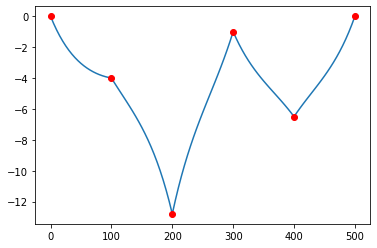

In [7]:
allval1 = np.zeros(N)
allval1[unknown_indexes] = Ec
allval1[observation_indexes] = depth
plt.plot(discretization, allval1)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()

6. Calculer la matrice de variance conditionnelle et tracer sa diagonale (variance conditionnelle) en fonction de la position. Commenter.

In [8]:
SigmaCond = SigmaUnknown - np.matmul(np.transpose(SigmaObsUnknown), np.matmul(np.linalg.inv(SigmaObs), SigmaObsUnknown))

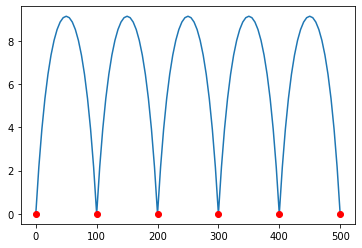

In [9]:
allval2 = np.zeros(N)
allval2[unknown_indexes] = np.diag(SigmaCond)
plt.plot(discretization, allval2)
plt.plot(discretization[observation_indexes], np.zeros(np.shape(observation_indexes)[0]), 'ro')
plt.show()

*On voit ici que la variance est nulle aux points de données (puisque la valeur est fixée) puis qu'elle augmente lorsqu'on s'éloigne des données*

7. Effectuer une simulation conditionnelle. Sur un même graphique, tracer la simulation ainsi que les données et l'espérance conditionnelle. Commenter.

In [10]:
Cholesky = np.linalg.cholesky(SigmaCond)
x = np.random.normal(0, 1, np.shape(unknown_indexes)[0])
simu = Ec + np.matmul(Cholesky, x)

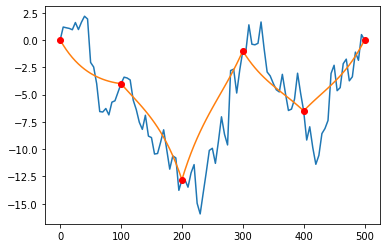

In [11]:
allval3 = np.zeros(N)
allval3[unknown_indexes] = simu
allval3[observation_indexes] = depth
plt.plot(discretization, allval3)
plt.plot(discretization, allval1)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()

*l'espérance conditionnelle est lisse car c'est la fonction des données qui minimise la variance ; la simulation conditionnelle reproduit les fluctuations du modèle et donc l'aspect du fond marin*

8. Ecrire une fonction qui calcule la longueur du câble en fonction du vecteur des profondeurs et du pas de discrétisation.

In [12]:
def length(z,delta):
    return sum(np.sqrt(Delta**2+(z[1:N]-z[0:-1])**2))

9. Utiliser cette fonction pour calculer la longueur du câble à partir de 100 simulations. Comparer l'espérance conditionnelle (estimée) de la longueur avec la longueur de l'espérance conditionnelle.

In [13]:
K = 100000
result = np.zeros(K)
for i in range(K):
    x = np.random.normal(0, 1, np.shape(unknown_indexes)[0])
    allval3[unknown_indexes] = Ec + np.matmul(Cholesky,x)
    result[i] = length(allval3, Delta)

In [14]:
sum(result)/K

522.4286070469344

In [15]:
length(allval1,Delta)

501.6468416918411

*On donne ici directement les résultats pour 100000 simulations (comparer la vitesse d'éxécution avec votre code pour voir l'intérêt de la vectorisation).*

*On voit ici que la longueur donnée par l'espérance conditionnelle est bien moindre que la longueur d'une simulation conditionnelle. Ceci est dû au fait que la simulation conditionnelle va reproduire les fluctuations attendues, au contraire de l'espérance conditionnelle qui minimise la variance.*

*NB : On remarquera que c'est le seul endroit où on a utilisé une boucle dans cette correction. On aurait pu s'en passer en utilisant notamment les outils de la librairie Pandas mais le code est plus lisible ainsi.*

10. Représenter la suite $M_n$ des moyennes des longueurs de câbles en fonction du nombre de simulations. Commenter.

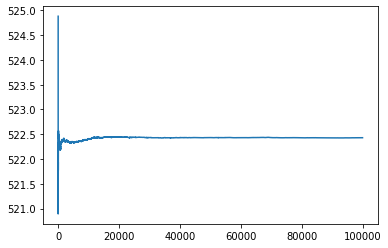

In [16]:
indice_simu = 1 + np.arange(K)
plt.plot(indice_simu, np.cumsum(result)/indice_simu)
plt.show()

*Comme attendu d'après la LFGN, on observe une stabilisation de la valeur moyenne. Les variations sont imperceptibles après quelques dizaines de milliers de simulations*

11. Représenter l'histogramme des longueurs de câbles générées.

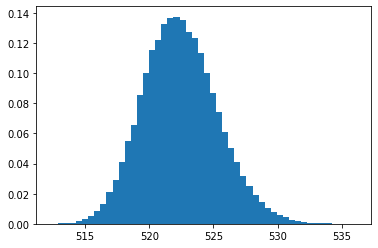

In [17]:
plt.hist(result, 50, density=True)
plt.show()

*L'histogramme ressemble à une densité gaussienne, avec néanmoins une légère dissymétrie (plus de valeurs fortes).*

12. Donner un intervalle de confiance à 95% de la longueur du câble par 2 méthodes différentes. Commenter.

*1ère méthode : par approximation gaussienne. L'histogramme précédent suggère qu'une loi gaussienne peut bien représenter la loi conditionnelle de la longueur du cable. On obtient un intervalle de confiance en calculant la moyenne (milieu de l'intervalle) et l'écart type de l'échantillon de longueurs de câble puis en appliquant la formule du cours.*

In [18]:
Ln = sum(result)/K
sigman = np.std(result)
[Ln - sigman*1.96, Ln + sigman*1.96]

[516.751417247477, 528.1057968463919]

*2e méthode : on extrait les quantiles à 2.5% et 97.5% de l'échantillon, c'est-à-dire les valeurs $x_\alpha$ pour $\alpha \in \{0.025 ; 0.975\}$telles que* $$\mathbb{P}(L<x_\alpha) \approx \frac{1}{n}\sum_{i=1}^N 1_{\{L_i<x_\alpha\}}$$

In [19]:
np.quantile(result,[0.025,0.975])

array([517.13219301, 528.46643487])

*ATTENTION : ici l'utilisation du TCL tel qu'exposé au début du chapitre 5 fournissait un intervalle de confiance de l'**espérance de la longueur de câble** et non de la **longueur de câble** (erreur fréquente).*

*On voit par ailleurs que la 2e méthode est plus précise car elle est basée directement sur la loi empirique de l'échantillon*

13. Donner une estimation de la probabilité que la longueur du câble dépasse 525 m.

In [20]:
np.mean(result>525)

0.18407

14. Reprendre les questions précédentes avec 1000, 10000 puis 100000 simulations. Commenter

*cf. le commentaire de la question 10. On observe une stabilisation progressive des estimateurs des différentes quantités calculées : moyennes, quantiles, probabilité de dépassement de seuil.*

# Enoncé 2021 (Partie 2)

Nous nous plaçons dans le même cadre que ci-dessus. Nous tenons pour acquis les résultats précédents et allons maintenant approfondir l'analyse.

## Valeurs positives

1. A la question 7 de la partie 1, on peut s'apercevoir que certains profils de profondeur présentent des valeurs positives, ce qui n'a pas de sens si on considère qu'il n'y a pas de partie émergée entre les deux côtes. Proposer et implémenter un algorithme de type rejet qui ne génèrera que des valeurs négatives. Représenter un profil de profondeur généré.

In [21]:
Cholesky = np.linalg.cholesky(SigmaCond)

# la fonction retourne la simulation et le nombre de rejets avant d'obtenir 
# une solution dont toutes les profondeurs sont négatives

def simulation():
    simu = np.zeros(np.shape(unknown_indexes)[0])
    rejets = 0
    while simu.max() >= 0 :
        x = np.random.normal(0, 1, np.shape(unknown_indexes)[0])
        simu = Ec + np.matmul(Cholesky, x)
        rejets += 1
    return simu, rejets

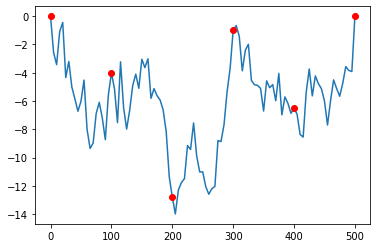

In [22]:
allval4 = np.zeros(N)
allval4[unknown_indexes], rejets = simulation()
allval4[observation_indexes] = depth
plt.plot(discretization, allval4)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()

In [23]:
# Nombre de rejets :
rejets

2

*Le nombre de rejets étant très faible, on garde la méthode de calcul avec la matrice de Cholenski qui nécessite de recalculer toutes les valeurs de la simulation dès qu'une seule de ces valeurs est positive. Le temps d'exécution reste en effet très rapide.*

2. L'emploi de cet algorithme a-t-il un impact sur la valeur moyenne de la longueur de câble ? Sur l'histogramme des longueurs de câble ? Sur l'intervalle de confiance obtenu par la méthode des quantiles ? Sur la probabilité de dépassement du seuil de 525 m? Donner une estimation du taux de rejet de l'algorithme. Considérer 10000 simulations.

In [24]:
def simulation2(nb_simulations):
    result = np.zeros(nb_simulations)
    for i in range(nb_simulations):
        allval4[unknown_indexes], rejets = simulation()
        result[i] = length(allval4, Delta)
    return result

In [25]:
# Pour 10 000 simulations :
resultat = simulation2(10000)
longueur_moy = sum(resultat)/10000
intervalle_confiance = np.quantile(resultat,[0.025,0.975])
seuil = np.mean(resultat>525)

In [26]:
# estimation du nombre de rejets moyen, calculée sur 10 000 itérations :
simu = np.zeros(np.shape(unknown_indexes)[0])
rejets = 0
for i in range(10000):
    x = np.random.normal(0, 1, np.shape(unknown_indexes)[0])
    simu = Ec + np.matmul(Cholesky, x)
    if simu.max() >= 0:
        rejets += 1

taux_rejet = rejets/10000

In [27]:
print ("NOUVELLES VALEURS : \nMoyenne de longueur du câble : ", longueur_moy, "\nIntervalle de confiance : ", 
       intervalle_confiance, "\nProbabilité de dépasser 525m : ", seuil, "\nTaux de rejet : ", taux_rejet)

NOUVELLES VALEURS : 
Moyenne de longueur du câble :  521.7882556576682 
Intervalle de confiance :  [516.62387679 527.49910093] 
Probabilité de dépasser 525m :  0.1291 
Taux de rejet :  0.9635


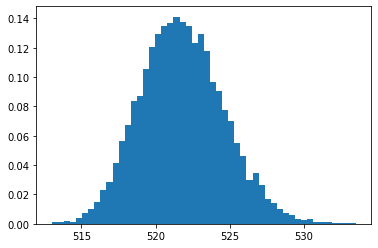

In [28]:
# Histogramme
plt.hist(resultat, 50, density=True)
plt.show()

*La longueur est légèrement plus basse, de même que les valeurs de l'intervalle de confiance et que la probabilité de dépasser 525m, ce qui n'est pas étonnant vu qu'on interdit les points émergés, ie qui s'éloignent du fond marin. Cependant cette variation n'est pas significative. L'histogramme, quant à lui, est sensiblement le même.*

*Le taux de rejet est relativement élevé : il y a environ 20 tentatives avant d'avoir un vecteur profondeur qui convient. Cependant, comme il a déjà été dit en question 1, ce n'est pas bien grave car le temps de calcul est assez rapide.*

## Approche Bayésienne

Dans la première partie, on a considéré que l'ensemble des paramètres du modèle était parfaitement connu. Toutes choses égales par ailleurs, on va maintenant considérer que la moyenne $\mu$ est issue d'une estimation entâchée d'une incertitude. Plus précisément, on va modéliser cette incertitude en considérant que $\mu \sim \mathcal{N}(-5,4)$.

On va également décomposer le vecteur $\mathbf{Z}$ en $\mathbf{Z} = (\mathbf{Z}_{\text{OBS}},\mathbf{Z}_{\text{UNK}})$. On notera $C_{\text{OBS}}$ et $C_{\text{UNK}}$ les matrices de covariance respectives de $\mathbf{Z}_{\text{OBS}}$ et $\mathbf{Z}_{\text{UNK}}$ ainsi que $C_{\text{OBS},\text{UNK}}$ la matrice des covariances entre ces deux vecteurs.

### Questions théoriques

3. Montrer que $\mu | \mathbf{Z}_{\text{OBS}}= \mathbf{z}_{\text{OBS}} \sim \mathcal{N}(\widehat{\mu},\widehat{\sigma}^2)$ avec
$$\widehat{\sigma}^2 = (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})^{-1},$$ 
où $\mathbf{1}$ est un vecteur de longueur 6 (soit la longueur du vecteur $\mathbf{Z}_{\text{OBS}}$) ne contenant que des 1 et 
$$\widehat{\mu} = \widehat{\sigma}^2 (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{z}_{\text{OBS}} - \frac{5}{4} )$$
Indication : écrire la densité jointe du vecteur $(\mathbf{Z}_{\text{OBS}},\mu)$, calculer $-2 \ln$ de cette densité puis identifier la forme quadratique faisant intervenir $\mu$.

on écrit la densité jointe du vecteur $(Z_{OBS},\mu)$, d'après la formule de Bayes :
$$ f_{Z_{OBS},\mu}(z_{obs},m) = f_{Z_{OBS}|\mu = m}(z_{obs}).f_{\mu}(m) = f_{\mu|Z_{OBS}=z_{obs}}(m).f_{Z_{OBS}}(z_{obs})\quad (1)$$
    
D'après le cours sur les vecteurs gaussiens aléatoires, $\mu|Z_{OBS}=z_{obs}$ suit une loi normale que l'on note $\mathcal{N}(\widehat{\mu},\widehat{\sigma}^2)$
    
donc $(1)$ devient :
    
$$\frac{1}{(2\pi)^3 \sqrt{det(C_{OBS})}}exp\left(-\frac{1}{2}(z_{obs}-1m)^TC_{OBS}^{-1}(z_{obs}-1m)\right).\frac{1}{2\sqrt{2\pi}}exp\left( -\frac{1}{2}\left( \frac{m+5}{2} \right)^2 \right) = \frac{1}{\sqrt{2\pi}\widehat{\sigma}}exp \left( -\frac{1}{2}\left( \frac{m-\widehat{\mu}}{\widehat{\sigma}}\right)^2 \right).f_{Z_{OBS}(z_{obs})}$$
    
on applique $-2ln( . )$ à l'égalité :
    
$$Cste(z_{obs}) + \left(\frac{m-\widehat{\mu}}{\widehat{\sigma}}\right)^2 = Cste + \left( z_{obs}-1m\right)^T C_{OBS}^{-1}\left( z_{obs}-1m\right) + \left( \frac{m+5}{2} \right)^2$$
    
on fait un plutôt long calcul et on arrive à identifier $\widehat{\sigma}^2 = (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})^{-1}$ et $\widehat{\mu} = \widehat{\sigma}^2 (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{z}_{\text{OBS}} - \frac{5}{4} )$

4. Montrer que si $X$, $Y$ et $Z$ sont trois vecteurs aléatoires à densité, alors $f_{X,Y|Z = z}(x,y) = f_{X|Y=y,Z=z}(x)f_{Y|Z=Z}(y)$

*On utilise 3 fois la propriété sur les densités conditionnelles :*

$ \newline (1) \qquad f_{(X,Y),Z} (x,y,z) = f_{Z} (z) f_{(X,Y) | Z = z} (x,y) $
$ \newline (2) \qquad f_{X,(Y,Z)} (x,y,z) = f_{Y,Z} (y,z) f_{X |(Y,Z) = (y,z)} (x) $
$ \newline (3) \qquad f_{Y,Z} (y,z) = f_{Z} (z) f_{Y | Z = z} (y) $

*On en déduit : $ f_{Z} (z) f_{(X,Y) | Z = z} (x,y) = f_{Y,Z} (y,z) f_{X |(Y,Z) = (y,z)} (x) = f_{Z} (z) f_{Y | Z = z} (y) f_{X |(Y,Z) = (y,z)} $, soit $ f_{X,Y|Z = z}(x,y) = f_{X|Y=y,Z=z}(x)f_{Y|Z=Z}(y) $, ce qui correspond au résultat attendu.*

5. En déduire que la densité de $(\mathbf{Z}_{\text{UNK}},\mu) | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$ s'écrit comme le produit de $f_{\mu | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ et de $f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ que l'on exprimera.

    Indication : $f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ est identique à la densité $f_{\mathbf{Z}_{\text{UNK}}| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ utilisée dans la partie 1 avec $\mu = \mu^\star$

*On utilise la question 4 et l'indication pour obtenir :* $\forall x \in \mathbb{R} $,

$ f_{\mathbf{Z}_{\text{UNK}},\mu | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}} (x) = f_{\mu | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}} (x) f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}} (x) 
    \qquad = \frac{1}{\widehat{\sigma}\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{x-\widehat{\mu}}{\widehat{\sigma}})^2} \frac{1}{(2\pi)^{47} \sqrt{\text{det}(CS_{\mathbf{Z}_{\text{UNK}}}})} \text{exp}(-\frac{1}{2} (x-\phi(\mathbf{z}_{\text{OBS}}))^{t}C{S_{{\mathbf{Z}}_{\text{UNK}}}^{-1}(x-\phi(\mathbf{z}_{\text{OBS}}))})$
    
*où on a :* 

$ C = \text{Cov}((\mathbf{Z}_{\text{UNK}},\mathbf{Z}_{\text{OBS}}), (\mathbf{Z}_{\text{UNK}},\mathbf{Z}_{\text{OBS}})) 
\newline CS_{\mathbf{Z}_{\text{UNK}}} = \text{Cov}(\mathbf{Z}_{\text{UNK}},\mathbf{Z}_{\text{UNK}}) - \text{Cov}(\mathbf{Z}_{\text{UNK}},\mathbf{Z}_{\text{OBS}}) . {\text{Cov}(\mathbf{Z}_{\text{OBS}},\mathbf{Z}_{\text{OBS}})}^{-1} . \text{Cov}(\mathbf{Z}_{\text{OBS}},\mathbf{Z}_{\text{UNK}})
\newline \phi(\mathbf{z}_{\text{OBS}}) = m + \text{Cov}(\mathbf{Z}_{\text{UNK}},\mathbf{Z}_{\text{OBS}}) . {\text{Cov}(\mathbf{Z}_{\text{OBS}},\mathbf{Z}_{\text{OBS}})}^{-1} (\mathbf{z}_{\text{OBS}} - m') $

*avec $m$ et $m'$ les vecteurs de taille respectivement 94 et 6 contenant uniquement la valeur $\mu$.*

### Simulation

On va maintenant chercher à simuler les valeurs de $\mathbf{Z}_{\text{UNK}}$ en tenant compte de l'incertitude sur $\mu$.

En première approche, on pourrait chercher à obtenir la densité de $\mathbf{Z}_{\text{UNK}} | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$ en calculant 
$$\int_\mathbb{R} f_{(\mathbf{Z}_{\text{UNK}},\mu) | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(\mathbf{z}_{\text{UNK}},\mu^\star) d\mu^\star$$
mais ce calcul a peu de chances d'aboutir.

On va plutôt procéder par simulations en cascade, c'est-à-dire que pour chaque simulation de $\mathbf{Z}_{\text{UNK}}$, on va d'abord générer une valeur $\mu^\star$ de $\mu$ selon $f_{\mu | \mathbf{Z}_{\text{OBS}}= \mathbf{z}_{\text{OBS}}}$ puis on simulera $\mathbf{Z}_{\text{UNK}}$ selon $f_{\mathbf{Z}_{\text{UNK}}| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}},\mu = \mu^\star}$.


6. Calculer $\widehat{\mu}$ et $\widehat{\sigma}^2$. 

In [29]:
# Calcul de sigma au carré :
uns = np.array([1 for i in range(6)])
sigma_hat2 = 1/(np.matmul(uns, np.matmul(np.linalg.inv(SigmaObs.T), uns)) + 1/4)
sigma_hat = np.sqrt(sigma_hat2)
sigma_hat2

1.5368909974762894

In [30]:
# Calcul de mu :
mu_hat = sigma_hat2 * (np.matmul(uns, np.matmul(np.linalg.inv(SigmaObs.T), depth)) - 5/4)
mu_hat

-4.291350330933772

7. Calculer la probabilité de $\{\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}} > 0\}$. Proposer et implémenter un algorithme de simulation de $\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}, \mu <0$.

*On a : $\mu | \mathbf{Z}_{\text{OBS}}= \mathbf{z}_{\text{OBS}} \sim \mathcal{N}(\widehat{\mu},\widehat{\sigma}^2)$, donc* 

$ \mathbb{P}(\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}} > 0) = 1 - \mathbb{P}(\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}} \leq 0) = 1 - F_{\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}} (0) = 1 - \frac{1}{\widehat{\sigma} \sqrt{2\pi}} \int_{-\infty}^{0} e^{-\frac{1}{2} (\frac{x-\widehat{\mu}}{\widehat{\sigma}})^2} \mathrm{d}x $

In [31]:
# Calcul de cette probabilité :
def f (x) :
    return np.exp( (-1/2) * ((x-mu_hat)**2 /sigma_hat2) )

P = 1 - (sigma_hat2*2*np.pi)**(-1/2) * intg.quad(f, -np.inf, 0)[0]
P

0.000268522638816604

*Finalement, $ \mathbb{P}(\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}} > 0) = 0.000268522638816604 $. Cette probabilité est très faible ; on peut implémenter la méthode du rejet et utiliser la générateur de variables gaussiennes de numpy.*

In [32]:
def simulation3():
    mu = 0
    while mu >= 0:
        mu = np.random.normal(mu_hat, sigma_hat2**(1/2))
    return mu

8. Générer un couple $\mathbf{Z}_{\text{UNK}}, \mu| \mathbf{Z}_{\text{OBS}}, \mu <0$ et représenter le profil de profondeur obtenu. On prendra soin de ne générer que des valeurs négatives de $\mathbf{Z}_{\text{UNK}}$ en utilisant l'algorithme de la section précédente.

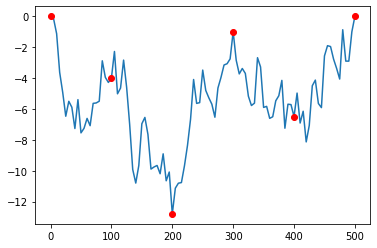

In [33]:
def simulation4():
    mu_ = simulation3()
    Ec_mu_ = mu_ + np.matmul(np.transpose(SigmaObsUnknown), np.matmul(np.linalg.inv(SigmaObs), depth-mu_))
    simu = np.zeros(np.shape(unknown_indexes)[0])
    while simu.max() >= 0 :
        x = np.random.normal(0, 1, np.shape(unknown_indexes)[0])
        simu = Ec_mu_ + np.matmul(Cholesky, x)
    return simu,mu_

Z_unk, mu_ = simulation4()
allval5 = np.zeros(N)
allval5[unknown_indexes] = Z_unk
allval5[observation_indexes] = depth
plt.plot(discretization, allval5)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()


*profil de profondeur obtenu*

----------------------------

9. Générer 10000 profils de profondeur et calculer les longueurs de câble associées. Comparer la valeur moyenne de la longueur de câble, dont on visualisera la convergence, l'histogramme des longueurs de câble, l'intervalle de confiance obtenu par la méthode des quantiles, la probabilité de dépassement du seuil de 525 m avec les résultats obtenus précédemment. Commenter.

In [34]:
K = 10000
result = np.zeros(K)
allval5 = np.zeros(N)
allval5[observation_indexes] = depth
for i in range(K):
    allval5[unknown_indexes] = simulation4()[0]
    result[i] = length(allval5,Delta)   
    

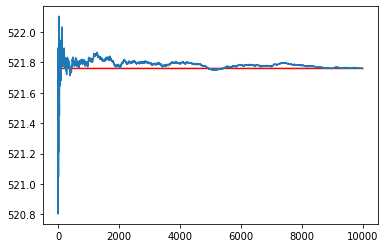

In [35]:
indice_simu = 1 + np.arange(K)
plt.plot(indice_simu, (sum(result)/K)*np.ones(K),color='red')
plt.plot(indice_simu, np.cumsum(result)/indice_simu)
plt.show()

*On observe la convergence de la valeur moyenne, comme attendu par la LFGN*

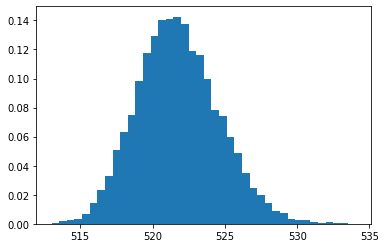

In [37]:
plt.hist(result, 40, density=True)
plt.show()

*histogramme des longueurs de cable obtenues, il ressembe à une gaussienne*

In [41]:
print ("NOUVELLES VALEURS : \nMoyenne de longueur du câble : ", sum(result)/K, "\nIntervalle de confiance : ", 
       np.quantile(resultat,[0.025,0.975]), "\nProbabilité de dépasser 525m : ", np.mean(result>525))

NOUVELLES VALEURS : 
Moyenne de longueur du câble :  521.7605712614128 
Intervalle de confiance :  [516.62387679 527.49910093] 
Probabilité de dépasser 525m :  0.1307


10. Qu'adviendrait-il selon vous si on rendait également aléatoires les autres paramètres du modèle $\sigma^2$ et $a$ ?

11. (facultatif) On suppose désormais que $\alpha = \frac1{\sigma^2} \sim \Gamma(a_1,a_2)$, où $\sigma^2$ correspond au paramètre qui intervient dans la fonction $C$. Donner l'expression de la densité de $\alpha | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$,  de $\mu | \alpha, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}},$ et de $\mathbf{Z}_{\text{UNK}} | \mu, \alpha, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$. Proposer un algorithme de simulation tenant compte de l'incertitude sur le paramètre $\alpha$ et analyser son impact sur les différentes quantités évaluées.

    Indication : Pour identifier la densité de $\alpha | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$, exprimer d'abord la densité jointe de $(\alpha,\mu, \mathbf{Z}_{\text{OBS}})$ puis marginaliser pour obtenir la densité de $(\alpha,\mathbf{Z}_{\text{OBS}})$
